# Spooky Author EDA

Let's start by importing the standard modules

In [2]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # better styling

%matplotlib inline

/Users/damien/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## General EDA (Model agnostic)

In [3]:
train = pd.read_csv('./data/train.csv')
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
# What percentage of documents belong to each author?
train.author.value_counts(normalize=True)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

i.e. we can get 40% accuracy by guessing Edgar Allen Poe (EAP) wrote all the books!

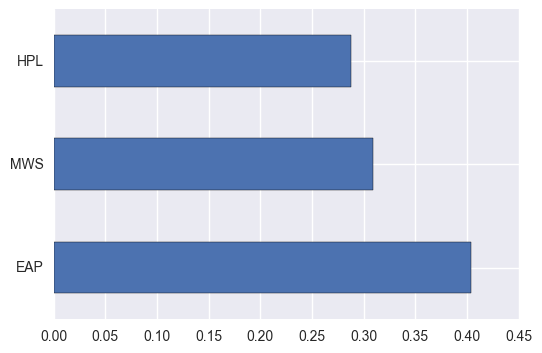

In [7]:
# see same info graphically:
train.author.value_counts(normalize=True).plot('barh');

In [10]:
print "Columns are ", list(train.columns)
print "Number of rows of data are", train.shape[0]

Columns are  ['id', 'text', 'author']
Number of rows of data are 19579


### Word frequency model

For each author:
1. Find the body of text they wrote
2. Remove the "stop words"
3. Find the (normalized) frequency of each word

In [72]:
import string
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    text = text.decode('unicode-escape').encode('ascii', 'ignore')
    return [word for word in nltk.word_tokenize(text.lower()) if word[0] in string.letters and word not in stopwords]


In [73]:
print "Original text:", train.text[0]
print "Cleaned text:", clean_text(train.text[0])

Original text: This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
Cleaned text: ['process', 'however', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', 'might', 'make', 'circuit', 'return', 'point', 'whence', 'set', 'without', 'aware', 'fact', 'perfectly', 'uniform', 'seemed', 'wall']


In [74]:
# nltk FreqDist gets the frequency distribution of a list
# Functionally similar to
def mock_freq_dist(iterable):
    freq_table = {}
    for item in iterable:
        freq_table[item] = freq_table.get(item, 0) + 1
    return freq_table

# Differences are that FreqDist has some nice helper functions (such as "most common")
nltk.FreqDist(clean_text(train.text[0]))

FreqDist({'afforded': 1,
          'ascertaining': 1,
          'aware': 1,
          'circuit': 1,
          'dimensions': 1,
          'dungeon': 1,
          'fact': 1,
          'however': 1,
          'make': 1,
          'means': 1,
          'might': 1,
          'perfectly': 1,
          'point': 1,
          'process': 1,
          'return': 1,
          'seemed': 1,
          'set': 1,
          'uniform': 1,
          'wall': 1,
          'whence': 1,
          'without': 1})

In [75]:
def process_text(all_author_text):
    return nltk.FreqDist(clean_text(all_author_text))

In [79]:
# Do this for all authors:
freq_dist = {}
for name, group in train.groupby('author'):
    author_text = group['text'].str.cat(sep=' ')
    freq_dist[name] = process_text(author_text)

In [88]:
# Frequency of EAP's work that is blood (this is one reason why nltk's FreqDist is better than my counter)
freq_dist['EAP'].freq('blood')

0.0003537834013152418

In [86]:
freq_dist['EAP'].most_common()

[('upon', 1025),
 ('one', 655),
 ('could', 457),
 ('would', 416),
 ('said', 356),
 ('little', 275),
 ('say', 267),
 ('well', 265),
 ('made', 263),
 ('time', 260),
 ('even', 260),
 ('man', 256),
 ('however', 254),
 ('thus', 254),
 ('first', 249),
 ('us', 235),
 ('yet', 232),
 ('much', 230),
 ('found', 229),
 ('great', 227),
 ('two', 213),
 ('long', 212),
 ('every', 206),
 ('never', 202),
 ('still', 196),
 ('must', 196),
 ('might', 188),
 ('without', 182),
 ('may', 181),
 ('length', 178),
 ('whole', 176),
 ('day', 176),
 ('within', 175),
 ('like', 173),
 ('thought', 170),
 ('although', 170),
 ('eyes', 168),
 ('indeed', 167),
 ('mr.', 164),
 ('head', 164),
 ('far', 162),
 ('many', 161),
 ('nothing', 153),
 ('seemed', 150),
 ('three', 150),
 ('way', 149),
 ('night', 146),
 ('let', 144),
 ('left', 140),
 ('good', 140),
 ('old', 139),
 ('matter', 139),
 ('thing', 135),
 ('point', 134),
 ('hand', 133),
 ('de', 132),
 ('see', 131),
 ('mind', 131),
 ('shall', 130),
 ('came', 128),
 ('course', 1

Can define the _bag of words_ model:

We use the frequencies to determine P(word | author). We assume the words are independent, so 
$$ \text{P(text | author)} = \prod_{i=1}^{\text{len(text)}} \text{max(P(word}_i \text{ | author)}, \varepsilon) $$

These numbers get small quickly, so use

$$ \log\text{P(text | author)} = \sum_{i} \text{max(log(P(word}_i \text{ | author)}), \log\varepsilon)$$

where $\varepsilon$ is a threshold to ensure rare words (which we won't encounter too often with our sampling) don't send the probability to zero.

We then pick the author with the greatest log likihood as the prediction.

In [97]:
def bag_of_words(text, epsilon = 10**-9):
    cleaned = clean_text(text)  # get an array of words
    
    cumulative = {}
    for author in freq_dist:
        score = np.log([max(freq_dist[author].freq(word), epsilon) for word in cleaned]).sum()
        cumulative[author] = score
    return sorted([(value, author) for author, value in cumulative.items()], reverse=True)
        
            

In [99]:
# Note we get back the scores for each author, ordered from highest to lowest. So this predicts that 
# 'it was a dark and stormy night' 
# was most likely from HPL
bag_of_words('it was a dark and stormy night')

[(-23.004961126996868, 'HPL'),
 (-24.677215395395059, 'MWS'),
 (-25.375509019948879, 'EAP')]

In [100]:
def bag_of_words_prediction(text,epsilon = 10**-9):
    return bag_of_words(text, epsilon)[0][1]

In [101]:
bag_of_words_prediction('it was a dark and stormy night')

'HPL'

In [ ]:
%%time
# Warning: this takes a long time to run
train['prediction'] = train.text.apply(lambda t: bag_of_words_prediction(t))